# Loading the data
No much to say here

In [1]:
from loading_data import loading_data
from IPython.display import display
path_to_data = './Data/'
(lin_tree, fates, fates2,
 fates3, vol, inv_lin_tree,
 surf_ex, surfaces, names,
 properties, ColorMap) = loading_data(path_to_data)

/Users/guignardl/Library/Python/2.7/lib/python/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Lineage tree data structure manipulation

## Cell ids

A cell id is a unique identifier for every cell at a given time point.

These ids are not random and from them can be extracted their time origin and their unique identifiant in their image origin (this id is not unique accross the whole movie).

- `cell_id = origin_time * 10**4 + origin_label`

so if you want to get back the time and the label of a cell you can do it that way:
- `origin_label = cell_id%10**4` is the corresonding label in the image
- `origin_time = cell_id//10**4` is the corresponding time (note that // is the floor division)

Practically, if a cell id is `1230341` then it means that its time in the movie is `123` and its label in the corresponding segmented image is `341`

## Dictionary data structure
[Dictionary python doc 1](https://docs.python.org/2/tutorial/datastructures.html#dictionaries)
[Dictionary python doc 2](https://docs.python.org/2/library/stdtypes.html#dict)

[A bit more on dictionaries](http://www.tutorialspoint.com/python/python_dictionary.htm)

The main methods that we will use are the following:
- [iteritems](https://docs.python.org/2/library/stdtypes.html#dict.iteritems)
- [get](https://docs.python.org/2/library/stdtypes.html#dict.get)
- [setdefault](https://docs.python.org/2/library/stdtypes.html#dict.setdefault)

## Lineage tree data structure

The lineage tree data structure is a dictionary where the key is a cell id at time `t` and the key is the list of its successors at time `t+1`.

Lets have a cell with the id `920257`

In [2]:
cell_id = 920257

Then its successors can be found that way:

In [3]:
succ = lin_tree[cell_id]
print(succ)

[930267]


In general, in our dataset (and generally in any of the datasets that we will generate during this course) the number of successors is either `1` or `2`

In the previous case `cell_id` has `1` successor meaning that the cell didn't divide.

If we now look at successors of the cell `1180194`

In [4]:
succ2 = lin_tree[1180194]
print(succ2)

[1190193, 1190194]


It has two successors meaning that the cell divided into two sister cells.

Therefore the lenght of the list of the successor of a given cell give the information about whether or not the cell will divide at the next time point.

Knowing that if we want to gather all the cell_ids that will divide at the next time point in a list, it can be done the following way:

In [5]:
list_of_dividing_cells = []
for cell_id, succ in lin_tree.iteritems():
    if len(succ) == 2:
        list_of_dividing_cells.append(cell_id)

`list_of_dividing_cells` contains all the cell ids of the cell that will divide at the next time point.

An other way to build this list, that is more a "pythonic" way and that is supposed to be faster, is the following:

In [6]:
list_of_dividing_cells_2 = [cell_id for cell_id, succ in lin_tree.iteritems() if len(succ) == 2]

if list_of_dividing_cells == list_of_dividing_cells_2:
    print "The two lists are equal."
else:
    print "The two lists are not equal."

print "Number of dividing cell accross the movie: %d"%len(list_of_dividing_cells)

The two lists are equal.
Number of dividing cell accross the movie: 639


## Basic operation on lineage tree (and tree graphs in general)

We will look at
- how to extract all the cell_ids of a given cell (meaning from when it appears to when it divides)
- how to extract all the cell_ids of the progeny of a given cell

### How to extract all the cell_ids of a given cell
- from the first cell id of the cell cycle:

We first get a cell that just divided:

In [7]:
cell_id = lin_tree[list_of_dividing_cells[100]][0]

Then, the idea here is to retreive all the successors until we get a division:

In [8]:
# Initialisation of the list of the cell cycle with the first cell
cell_cycle = [cell_id]

# The current cell is the first cell
current_cell = cell_id

# While current cell does not divide at the next time point,
while len(lin_tree.get(current_cell, [])) == 1:
    # we update the current cell to its successor
    current_cell = lin_tree[current_cell][0]
    # we add the successor to the list of the ids
    cell_cycle.append(current_cell)

An other version (slightly) more efficient (less readable)

In [9]:
cell_cycle2 = [cell_id]
while len(lin_tree.get(cell_cycle2[-1], [])) == 1:
    cell_cycle2 += lin_tree[ cell_cycle2[-1] ]
    
print(cell_cycle == cell_cycle2)

True


- from the last cell of the cell cycle

We first get a cell that will divide

In [10]:
cell_id = cell_cycle[-1]

Then again the idea is to retreive all the predecessors until "fusion" to its sister cell to form the mother

In [11]:
cell_cycle_reverse = [cell_id]
current_cell = inv_lin_tree[cell_id]

# while the current cell does not divide at the next time point
# we add it to the list and get its predecessor
while len(lin_tree.get(current_cell, [])) == 1:
    cell_cycle_reverse.append(current_cell)
    current_cell = inv_lin_tree[current_cell]

An other version (slightly) more efficient (less readable)

In [12]:
cell_cycle_reverse2 = [cell_id]
while len(lin_tree.get(inv_lin_tree[cell_cycle_reverse2[-1]], [])) == 1:
    cell_cycle_reverse2.append(inv_lin_tree[cell_cycle_reverse2[-1]])
    
print("Check if the two lists are the same")
print(cell_cycle_reverse == cell_cycle_reverse2)

print("Check if the two created list are the same in the reverse order")
print(cell_cycle_reverse == cell_cycle[::-1])

Check if the two lists are the same
True
Check if the two created list are the same in the reverse order
True


- From any given cell during the cell cycle

We first get a cell id in the cell cycle:

In [13]:
cell_id = cell_cycle[10]

Then the idea to combine the two previous methods:

In [14]:
# I am a bit lazy but you probably ca do it yourself as an exercice
# I just start for you:
cell_cycle_mid = []

In [15]:
# your code here. Careful there is a trick with the order of the list.
# At some point you might want to insert cell ids to your list instead of appending them

In [16]:
# Then we check if you are correct:
print(cell_cycle_mid == cell_cycle)

False


### Getting all the clonal cells from a given cell id
To do so we will do what is called a [Depth-First Search](https://en.wikipedia.org/wiki/Depth-first_search) on our lineage tree from our cell id.

In [17]:
cell_id = cell_cycle[0]

clonal_cells = []
cells_to_treat = [cell_id]

while cells_to_treat != []:
    current_cell = cells_to_treat.pop(-1)
    clonal_cells.append(current_cell)
    cells_to_treat += lin_tree.get(current_cell, [])

# Accessing cell properties

All the cell properties are stored in dictionaries where the key is a cell id for which is mapped its metric.

For example `vol` is the dictionary for the volumes and the volume of the cell `cell_id` can be retrieve that way:

In [18]:
vol[cell_id]

119428.0

The volume is in voxels. Knowing the dimension of the voxels it is possible to convert the volume in $\mu m^3$ (here it is $ 0.3\mu m \times 0.3\mu m \times 0.3\mu m $ ):

In [19]:
vol[cell_id]*.3**3

3224.5559999999996

Now it is possible to retrieve all the volumes for a given cell through its cell cycle.

In [20]:
cell_cycle_volume = []
# the cell_cycle list is the list previously generated
for c in cell_cycle:
    cell_cycle_volume.append(vol[c])
    
# An other more pythonic way:
cell_cycle_volume = [vol[c] for c in cell_cycle]

Using the numpy library we can then compute some statistics on these volumes:

In [21]:
import numpy as np

print("The average:")
print(np.mean(cell_cycle_volume))

print("The median:")
print(np.median(cell_cycle_volume))

print("The standard deviation:")
print(np.std(cell_cycle_volume))

The average:
115195.822222
The median:
114466.0
The standard deviation:
4775.20358281


And we can plot the evolution of volume using matplotlib tools:

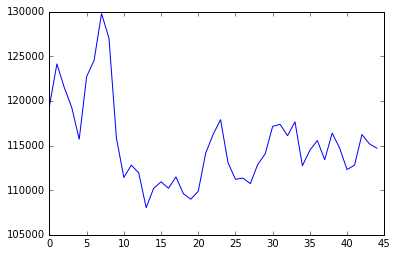

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(cell_cycle_volume)

### Accessing the surface of contact

The dictionary that link a cell_id to its surface of contact is slightly more complicated since it is a dictionary of dictionaries.

This dictionary is called `surf_ex` (for surface exchange).

This is the value for a given cell id:

In [23]:
surf_ex[cell_id]

{820001: 4255.0,
 820153: 41.0,
 820154: 639.0,
 820181: 2730.0,
 820183: 1579.0,
 820187: 1339.0,
 820188: 1091.0,
 820189: 618.0,
 820194: 44.0,
 820217: 2.0}

So it is a dictionary, this dictionary contains as keys all the ids of the neighbors of this cell id at this given time point.

To these neighbors is mapped the surface of contact they share with the cell `cell_id`.
The cell with the id `time * 10**4 + 1` is the "cell" that represent the exterior.

Therefore the cell `cell_id` shares an area of contact with the exterior of:

In [24]:
cell_id_time = cell_id//10**4
surf_ex[cell_id][cell_id_time * 10**4 + 1]

4255.0

Which gives in $\mu m^2$:

In [25]:
surf_ex[cell_id][cell_id_time * 10**4 + 1] * .3**2

382.94999999999999

### Accessing the different cell fates

The dictionary to access the cell fates is `fates3`
It has cell ids has keys to which it maps a string that represent this cell fate.

In [26]:
fates3[cell_id]

'Epidermis Tail'

Since some cells might not have their fate determined at all times during the development not all cells has a mapped fate in the `fate3` dictionary:

In [27]:
cell_with_no_fate = 410097

print(fates3.has_key(cell_with_no_fate))

False


To avoid execution errors it is preferable to call the fate dictionary that way:

In [28]:
print(fates3.get(cell_id, 'Undetermined'))
print(fates3.get(cell_with_no_fate, 'Undetermined'))

Epidermis Tail
Undetermined


Eventhough the cell `cell_with_no_fate` does not have a fate specified yet, it is possible that its daughter is:

In [29]:
daughter1, daughter2 = lin_tree[cell_with_no_fate]
print('Fate of the first daughter:')
print(fates3.get(daughter1, 'Undetermined'))
print('Fate of the seconde daughter:')
print(fates3.get(daughter2, 'Undetermined'))

Fate of the first daughter:
Undetermined
Fate of the seconde daughter:
Endoderm Head


### Exercices:

1) We can now try to compute the surface of contact between the cell `cell_id` and to the 'Epidermis Tail' tissue

In [30]:
tissue_name = 'Epidermis Tail'
surface_of_contact = surf_ex[cell_id]

# Now compute how much the cell cell_id share with the Tail epidermis tissue

2) Computation of the evolution of volume of the previously determined clone

The first step is to arrange the cells by time points in a dictionary.

In [31]:
clonal_cells_by_time = {}

## HERE IS YOUR CODE

result = {82: [820182], 83: [830184], 84: [840187], 85: [850201], 86: [860208],
          87: [870219], 88: [880225], 89: [890232], 90: [900245], 91: [910253],
          92: [920255], 93: [930265], 94: [940265], 95: [950266], 96: [960268],
          97: [970265], 98: [980270], 99: [990272], 100: [1000284], 101: [1010286],
          102: [1020288], 103: [1030286], 104: [1040285], 105: [1050289], 106: [1060290],
          107: [1070292], 108: [1080297], 109: [1090297], 110: [1100300], 111: [1110305],
          112: [1120305], 113: [1130302], 114: [1140308], 115: [1150299], 116: [1160301],
          117: [1170294], 118: [1180294], 119: [1190294], 120: [1200294], 121: [1210297],
          122: [1220299], 123: [1230297], 124: [1240299], 125: [1250296], 126: [1260302],
          127: [1270301, 1270300], 128: [1280304, 1280303], 129: [1290305, 1290304],
          130: [1300310, 1300309], 131: [1310311, 1310310], 132: [1320312, 1320311],
          133: [1330314, 1330313], 134: [1340323, 1340322], 135: [1350335, 1350334],
          136: [1360333, 1360332], 137: [1370351, 1370350], 138: [1380359, 1380358],
          139: [1390364, 1390363], 140: [1400375, 1400374], 141: [1410388, 1410387],
          142: [1420389, 1420388], 143: [1430388, 1430387], 144: [1440390, 1440389],
          145: [1450398, 1450397], 146: [1460399, 1460398], 147: [1470406, 1470405],
          148: [1480410, 1480409], 149: [1490411, 1490410], 150: [1500420, 1500419],
          151: [1510419, 1510418], 152: [1520423, 1520422], 153: [1530427, 1530426],
          154: [1540428, 1540427], 155: [1550431, 1550430], 156: [1560425, 1560424],
          157: [1570428, 1570427], 158: [1580424, 1580423], 159: [1590432, 1590431],
          160: [1600437, 1600436], 161: [1610436, 1610435], 162: [1620440, 1620439],
          163: [1630438, 1630437], 164: [1640440, 1640439], 165: [1650445, 1650444],
          166: [1660445, 1660444], 167: [1670446, 1670445], 168: [1680446, 1680445],
          169: [1690440, 1690439], 170: [1700435, 1700434], 171: [1710437, 1710436],
          172: [1720434, 1720433], 173: [1730435, 1730434], 174: [1740433, 1740432],
          175: [1750427, 1750426], 176: [1760429, 1760428], 177: [1770428, 1770427],
          178: [1780427, 1780426], 179: [1790424, 1790423], 180: [1800423, 1800422]}

if result == clonal_cells_by_time:
    print("Correct")
else:
    print("False")

False


Then, for each cell id for each time point you want to extract their volumes

In [32]:
clonal_volume = {}

result = {82: [119428.0], 83: [124136.0], 84: [121478.0], 85: [119256.0], 86: [115699.0],
          87: [122730.0], 88: [124530.0], 89: [129786.0], 90: [127019.0], 91: [115840.0],
          92: [111425.0], 93: [112797.0], 94: [111942.0], 95: [108040.0], 96: [110194.0],
          97: [110934.0], 98: [110213.0], 99: [111482.0], 100: [109605.0], 101: [108989.0],
          102: [109874.0], 103: [114144.0], 104: [116247.0], 105: [117895.0], 106: [113085.0],
          107: [111219.0], 108: [111353.0], 109: [110734.0], 110: [112885.0], 111: [114067.0],
          112: [117139.0], 113: [117376.0], 114: [116097.0], 115: [117657.0], 116: [112740.0],
          117: [114466.0], 118: [115560.0], 119: [113412.0], 120: [116392.0], 121: [114717.0],
          122: [112307.0], 123: [112793.0], 124: [116233.0], 125: [115197.0], 126: [114700.0],
          127: [60382.0, 60085.0], 128: [59006.0, 59742.0], 129: [57914.0, 58567.0],
          130: [57317.0, 60019.0], 131: [56135.0, 59411.0], 132: [56403.0, 58881.0],
          133: [55249.0, 57858.0], 134: [55693.0, 57399.0], 135: [54288.0, 56309.0],
          136: [55242.0, 55297.0], 137: [56015.0, 53537.0], 138: [56255.0, 53509.0],
          139: [56523.0, 52700.0], 140: [57111.0, 54844.0], 141: [56566.0, 54288.0],
          142: [55501.0, 55671.0], 143: [54924.0, 56117.0], 144: [54946.0, 55307.0],
          145: [55240.0, 55296.0], 146: [54916.0, 53647.0], 147: [54277.0, 53867.0],
          148: [54274.0, 54900.0], 149: [53638.0, 54007.0], 150: [54322.0, 53717.0],
          151: [53547.0, 54806.0], 152: [53676.0, 54612.0], 153: [53219.0, 55120.0],
          154: [52982.0, 55584.0], 155: [55271.0, 56741.0], 156: [54130.0, 55329.0],
          157: [54766.0, 55222.0], 158: [56301.0, 55350.0], 159: [53804.0, 54176.0],
          160: [55495.0, 55244.0], 161: [55523.0, 55606.0], 162: [55887.0, 56082.0],
          163: [55380.0, 56095.0], 164: [55692.0, 57524.0], 165: [54489.0, 57252.0],
          166: [54348.0, 56541.0], 167: [55066.0, 57270.0], 168: [55011.0, 55895.0],
          169: [55027.0, 55438.0], 170: [57057.0, 56374.0], 171: [55523.0, 56280.0],
          172: [55290.0, 56518.0], 173: [55131.0, 56931.0], 174: [54137.0, 56736.0],
          175: [55847.0, 56646.0], 176: [56126.0, 56558.0], 177: [55254.0, 56330.0],
          178: [55261.0, 56719.0], 179: [54032.0, 55280.0], 180: [54374.0, 55804.0]}

if result == clonal_volume:
    print("Correct")
else:
    print("False")

False


Then, for each time point you want to get the sum of volume of the cells

In [33]:
clonal_volume_sum = {}

result = {82: 119428.0, 83: 124136.0, 84: 121478.0, 85: 119256.0, 86: 115699.0,
          87: 122730.0, 88: 124530.0, 89: 129786.0, 90: 127019.0, 91: 115840.0,
          92: 111425.0, 93: 112797.0, 94: 111942.0, 95: 108040.0, 96: 110194.0,
          97: 110934.0, 98: 110213.0, 99: 111482.0, 100: 109605.0, 101: 108989.0,
          102: 109874.0, 103: 114144.0, 104: 116247.0, 105: 117895.0, 106: 113085.0,
          107: 111219.0, 108: 111353.0, 109: 110734.0, 110: 112885.0, 111: 114067.0,
          112: 117139.0, 113: 117376.0, 114: 116097.0, 115: 117657.0, 116: 112740.0,
          117: 114466.0, 118: 115560.0, 119: 113412.0, 120: 116392.0, 121: 114717.0,
          122: 112307.0, 123: 112793.0, 124: 116233.0, 125: 115197.0, 126: 114700.0,
          127: 120467.0, 128: 118748.0, 129: 116481.0, 130: 117336.0, 131: 115546.0,
          132: 115284.0, 133: 113107.0, 134: 113092.0, 135: 110597.0, 136: 110539.0,
          137: 109552.0, 138: 109764.0, 139: 109223.0, 140: 111955.0, 141: 110854.0,
          142: 111172.0, 143: 111041.0, 144: 110253.0, 145: 110536.0, 146: 108563.0,
          147: 108144.0, 148: 109174.0, 149: 107645.0, 150: 108039.0, 151: 108353.0,
          152: 108288.0, 153: 108339.0, 154: 108566.0, 155: 112012.0, 156: 109459.0,
          157: 109988.0, 158: 111651.0, 159: 107980.0, 160: 110739.0, 161: 111129.0,
          162: 111969.0, 163: 111475.0, 164: 113216.0, 165: 111741.0, 166: 110889.0,
          167: 112336.0, 168: 110906.0, 169: 110465.0, 170: 113431.0, 171: 111803.0,
          172: 111808.0, 173: 112062.0, 174: 110873.0, 175: 112493.0, 176: 112684.0,
          177: 111584.0, 178: 111980.0, 179: 109312.0, 180: 110178.0}

if result == clonal_volume_sum:
    print("Correct")
else:
    print("False")

False


And ultimately you want to plot the evolution of volume of the clone in time

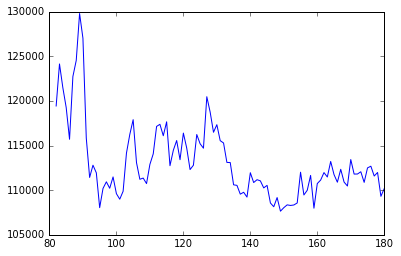

In [34]:
time = sorted(result.keys())
plt.plot(time, [result[t] for t in time])

3) Computation of the evolution of surface of a clone using only `surf_ex` (and not `surfaces`)

As for the previous exercice the first step is to sort the cells by time point

This is the solution for the first part of the previous exercice but instead of a list of cell we have a set of cells. It matters for the next steps of the computation

In [35]:
clonal_cells_by_time = {}
for c in clonal_cells:
    clonal_cells_by_time.setdefault(c/10**4, set()).add(c)

Then for each time point we want to compute the surface of the clone.
For the first time points (before the first division) it will be the actual surface of the cell but then it is slightly more complicated

In [36]:
clonal_cell_surface = {}

result = {82: 12338.0, 83: 12722.0, 84: 12935.0, 85: 13664.0, 86: 13472.0,
          87: 15131.0, 88: 15711.0, 89: 16906.0, 90: 17568.0, 91: 15289.0,
          92: 14817.0, 93: 15135.0, 94: 14893.0, 95: 14532.0, 96: 14662.0,
          97: 14478.0, 98: 14227.0, 99: 15070.0, 100: 14741.0, 101: 15245.0,
          102: 14265.0, 103: 14552.0, 104: 14941.0, 105: 15845.0, 106: 14695.0,
          107: 14457.0, 108: 14017.0, 109: 13848.0, 110: 13931.0, 111: 14089.0,
          112: 13905.0, 113: 13883.0, 114: 14002.0, 115: 14258.0, 116: 13746.0,
          117: 13759.0, 118: 13944.0, 119: 13489.0, 120: 13565.0, 121: 13195.0,
          122: 13107.0, 123: 12771.0, 124: 12726.0, 125: 12471.0, 126: 12715.0,
          127: 14105.0, 128: 14495.0, 129: 14969.0, 130: 15287.0, 131: 15384.0,
          132: 15566.0, 133: 15762.0, 134: 15603.0, 135: 15506.0, 136: 15601.0,
          137: 15304.0, 138: 15307.0, 139: 15109.0, 140: 15268.0, 141: 15528.0,
          142: 15369.0, 143: 15509.0, 144: 15365.0, 145: 15048.0, 146: 15086.0,
          147: 15009.0, 148: 15087.0, 149: 14868.0, 150: 14944.0, 151: 15282.0,
          152: 15148.0, 153: 15178.0, 154: 15047.0, 155: 15117.0, 156: 15107.0,
          157: 14902.0, 158: 14690.0, 159: 14593.0, 160: 14483.0, 161: 14728.0,
          162: 14493.0, 163: 14749.0, 164: 14974.0, 165: 14976.0, 166: 14858.0,
          167: 14981.0, 168: 14881.0, 169: 14985.0, 170: 15343.0, 171: 15370.0,
          172: 15315.0, 173: 15431.0, 174: 15339.0, 175: 15466.0, 176: 15576.0,
          177: 15242.0, 178: 15334.0, 179: 15425.0, 180: 15419.0}

if result == clonal_cell_surface:
    print("Correct")
else:
    print("False")

False


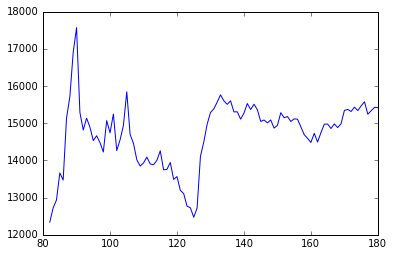

In [37]:
time = sorted(result.keys())
plt.plot(time, [result[t] for t in time])

4) Plot of the compactness of the clone over time

The formula for the compactness can be defined as follow:
$$
\frac{\sqrt[3]{\text{Vol}}}{\sqrt{\text{Surf}}}
$$

In [38]:
clonal_compactness = {}

result = {82: 0.4433496162253327, 83: 0.44227075229152613, 84: 0.43546106245873217,
          85: 0.42108633964640602, 86: 0.41981746126765668, 87: 0.40400160994013173,
          88: 0.39840313609880235, 89: 0.38939363674852073, 90: 0.37925245582193828,
          91: 0.39424238121807026, 92: 0.39531874425801489, 93: 0.39274256338885405,
          94: 0.39491769411991723, 95: 0.39509254092342, 96: 0.39593391882518103,
          97: 0.39933183896468422, 98: 0.40196441615818251, 99: 0.39205315906766475,
          100: 0.39416674624563813, 101: 0.3868689204598148, 102: 0.40101666767746436,
          103: 0.40212062867442139, 104: 0.39927374357773571, 105: 0.38954025166353645,
          106: 0.3989179135713854, 107: 0.39996369460400855, 108: 0.40635577606944084,
          109: 0.40806887300210615, 110: 0.40946891055881168, 111: 0.40858265104227354,
          112: 0.41493653324100188, 113: 0.415545043567071, 114: 0.41226705333235941,
          115: 0.41037095821776909, 116: 0.41203854069606011, 117: 0.4139349213454257,
          118: 0.41248563059314053, 119: 0.4167700087356363, 120: 0.4192095276413787,
          121: 0.42299759331525927, 122: 0.42142208590373681, 123: 0.42754476864122992,
          124: 0.43261063299126179, 125: 0.43570888560148002, 126: 0.43088656897217958,
          127: 0.41584947080815404, 128: 0.40825639038874045, 129: 0.39916761818548985,
          130: 0.3959581564431241, 131: 0.39269044694859528, 132: 0.39009270836150955,
          133: 0.38520403962949545, 134: 0.38714463085068962, 135: 0.38547648697709197,
          136: 0.38423385260662868, 137: 0.38678618902261719, 138: 0.3869975960491055,
          139: 0.38888408766240773, 140: 0.39005282031498378, 141: 0.38550146102922395,
          142: 0.3878606023809269, 143: 0.3859543055385663, 144: 0.38683924132710346,
          145: 0.39122673353015003, 146: 0.38839493732823716, 147: 0.38888834802625599,
          148: 0.3891093162576606, 149: 0.39012610443806434, 150: 0.38960700415811023,
          151: 0.38564722951633146, 152: 0.38727173037522061, 153: 0.3869495387325666,
          154: 0.38890153010155981, 155: 0.39206256544143797, 156: 0.38918973532190243,
          157: 0.39248779429322905, 158: 0.39729214128795415, 159: 0.39419291702037723,
          160: 0.39902882297238812, 161: 0.39615996171476353, 162: 0.40036255648170505,
          163: 0.39628825933247658, 164: 0.39533659848536479, 165: 0.39358596390432243,
          166: 0.39413891072235263, 167: 0.39421751551919887, 168: 0.39385432811017129,
          169: 0.39196431076092053, 170: 0.39080080030018521, 171: 0.38858039488519003,
          172: 0.38928331725511417, 173: 0.38811082325818863, 174: 0.38789133300200163,
          175: 0.38816779153552089, 176: 0.38701350103968285, 177: 0.38995365615625649,
          178: 0.38924145884955924, 179: 0.38498460269886087, 180: 0.3860736759077939}

if result == clonal_cell_surface:
    print("Correct")
else:
    print("False")

False


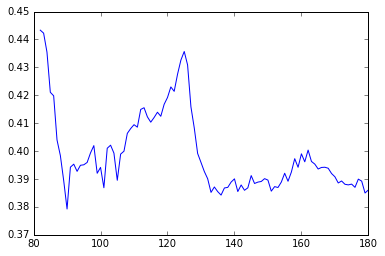

In [39]:
time = sorted(result.keys())
plt.plot(time, [result[t] for t in time])

### Complex exercice:
5) Computation of the angle of division to the main axis of the mother cell

You are given:
- the cells center of mass

In [47]:
center_of_mass = properties['barycenter'][0]

The center of mass of a cell at a time is a `tuple` of 3 `floats` that represent the `x, y, z` position

In [52]:
center_of_mass[cell_id]

(462.86693954237404, 380.20586459102196, 535.01818425820306)

- The main directions of the cells (ie the eigen vectors) together with the length of the directions (ie values)

In [53]:
eig_vectors = properties['axis_n'][0]
eig_values = properties['vals_n'][0]

The eigen vectors linked to a given cell at a given time is a list of 3 vectors represented by 3 numpy arrays.
The vectors are ordered from the main axis to the 3rd axis

In [60]:
eig_vectors[cell_id]

[array([ 0.91948896,  0.21655744, -0.32808982]),
 array([ 0.35555953, -0.10214057,  0.92905583]),
 array([-0.16768267,  0.97091204,  0.17091619])]

The eigen values are the values linked to the vectors from eig_vectors.

The highest eigen value refers to the main component of the cell (this array is sorted)

In [62]:
eig_values[cell_id]

array([ 242.28540925,  176.3531453 ,  158.94634495])

As an example, this is the code to get the main axis of the cell `cell_id`

In [63]:
main_axis = eig_vectors[cell_id][0]
print main_axis

[ 0.91948896  0.21655744 -0.32808982]


- The angle $\theta $ between two vectors $A$ and $B$ can be determined by the dot product:

$$
\theta = \arccos{\frac{A\cdot B}{||A||}}
$$

Alright, you should have everything needed